reference
- https://github.com/huggingface/transformers/blob/master/src/transformers/modeling_albert.py
- https://github.com/google-research/ALBERT/blob/master/modeling.py

In [1]:
import torch
import torch.nn as nn
import numpy as np
import math
from functools import reduce

In [2]:
def get_num_params(model):
    n_params = 0
    for param in model.parameters():
        param_shape = list(param.shape)
        n_params += reduce(lambda x, y: x*y, param_shape)
    return n_params

#### input/output embedding

In [1]:
from transformers import BertModel, BertTokenizer
import torch

model_nm = 'bert-large-uncased'
tokenizer = BertTokenizer.from_pretrained(model_nm)
model = BertModel.from_pretrained(model_nm)
input_ids = torch.tensor(tokenizer.encode("Hello, my dog is cute", add_special_tokens=True)).unsqueeze(0)  # Batch size 1
outputs = model(input_ids)
last_hidden_states = outputs[0]  # The last hidden-state is the first element of the output tuple

I0201 02:40:30.029308 140022660851456 file_utils.py:38] PyTorch version 1.1.0 available.
/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
I0201 02:40:32.252363 140022660851456 tokenization_utils.py:418] loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-vocab.txt from cache at /root/.cache/torch/transformers/9b3c03a36e83b13d5ba95ac965c9f9074a99e14340c523ab405703179e79fc46.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
I0201 02:40:33.134938 140022660851456 configuration_utils.py:233] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-config.json from cache at /root/.cache/torch/transformers/6dfaed860471b03ab5b9acb6153bea82b6632fb9bbe514d3ff

In [2]:
input_ids = torch.tensor(tokenizer.encode("Hello, my dog is cute", add_special_tokens=True)).unsqueeze(0)  # Batch size 1
outputs = model(input_ids)
last_hidden_states = outputs[0]  # The last hidden-state is the first element of the output tuple

In [3]:
emb_output = model.embeddings(input_ids)
emb_output.shape

torch.Size([1, 8, 1024])

In [4]:
attention_mask = torch.ones(input_ids.shape)
extended_attention_mask = attention_mask[:, None, None, :]
extended_attention_mask = extended_attention_mask.to(dtype=torch.float32)
extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0

In [5]:
n_layers = model.config.num_hidden_layers
n_layers

24

In [6]:
head_mask = [None] * n_layers

In [7]:
trans = model.encoder(emb_output, extended_attention_mask, head_mask)

In [8]:
trans[0].shape, trans[0].sum()

(torch.Size([1, 8, 1024]), tensor(-27.9191, grad_fn=<SumBackward0>))

In [9]:
hidden_states = emb_output
dist = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
distance_list = []

for i, layer in enumerate(model.encoder.layer):
    input_embedding = hidden_states
    out = layer(
        hidden_states,
        extended_attention_mask,
        head_mask[i],
    )
    output_embedding = out[0]
    distance = torch.dist(input_embedding, output_embedding, p=2)
    distance_list.append(distance)
    print(i, input_embedding.shape, output_embedding.shape, distance)

0 torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) tensor(35.7552, grad_fn=<DistBackward>)
1 torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) tensor(40.1659, grad_fn=<DistBackward>)
2 torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) tensor(42.7441, grad_fn=<DistBackward>)
3 torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) tensor(42.5579, grad_fn=<DistBackward>)
4 torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) tensor(45.1392, grad_fn=<DistBackward>)
5 torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) tensor(37.5907, grad_fn=<DistBackward>)
6 torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) tensor(36.1166, grad_fn=<DistBackward>)
7 torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) tensor(40.5871, grad_fn=<DistBackward>)
8 torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) tensor(50.8445, grad_fn=<DistBackward>)
9 torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) tensor(51.9049, grad_fn=<DistBackward>)
10 torch.Size([1, 8, 1024]) torch.Size([1, 8, 1024]) tensor(57.1084, grad_fn=<Di

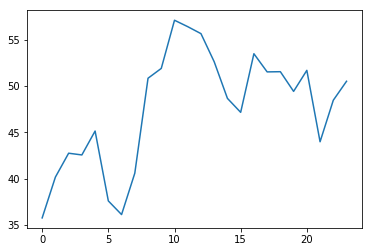

In [11]:
import matplotlib.pyplot as plt
plt.plot(distance_list)
plt.show()

#### Can BERT do SOP?

In [1]:
import numpy as np
import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM, BertForNextSentencePrediction
#from transformers import BertTokenizer, BertModel, BertForMaskedLM, BertForNextSentencePrediction

In [2]:
model_nm = 'bert-base-uncased'

In [3]:
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained(model_nm)

In [12]:
# NSP label should be 0
sent_1 = 'How old are you?'
sent_2 = 'I am 35 years old'

# NSP label should be 1
sent_1 = 'How old are you?'
sent_2 = 'The Eiffel Tower is in Paris'

sent_1 = 'is Obama the president of the US?'
sent_2 = 'No but he was'

In [16]:
# Tokenized input
text = ' '.join(['[CLS]', sent_1, '[SEP]', sent_2, '[SEP]'])
text = ' '.join(['[CLS]', sent_2, '[SEP]', sent_1, '[SEP]'])
tokenized_text = tokenizer.tokenize(text)

# Convert token to vocabulary indices
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
segments_ids = (len(tokenizer.tokenize(sent_1))+2)*[0] + (len(tokenizer.tokenize(sent_2))+1)*[1]

# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

In [6]:
# Load pre-trained model (weights)
model = BertForNextSentencePrediction.from_pretrained(model_nm)
model.eval()

BertForNextSentencePrediction(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): FusedLayerNorm(torch.Size([768]), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): FusedLayerNorm(torch.Size([768]), eps=1e-12, eleme

In [17]:
output = model(tokens_tensor, segments_tensors)
logits = output[0]
logits

tensor([ 5.5330, -4.8882], grad_fn=<SelectBackward>)

In [18]:
if logits[0] < logits[1]:
    print('they are random sentences')
else:
    print('they are in relation')

they are in relation
